In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk import sent_tokenize,word_tokenize 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import r2_score
import folium
import seaborn as sns
from scipy import stats
import json
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer


import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict

import pprint
import warnings
warnings.filterwarnings('ignore')
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors

from nltk.draw.dispersion import dispersion_plot

In [4]:
#!pip install gensim==3.6.0
#! conda list| findstr gensim

gensim                    3.6.0                    pypi_0    pypi


In [5]:
dataset = 'winemag-data-130k-v2.csv'

In [12]:
df = pd.read_csv(dataset, index_col = 'Unnamed: 0')

In [13]:
df = df.dropna(subset=["country", "description", "points", "price", "province", "variety"]).reset_index().drop("index", axis=1)
df = df.drop_duplicates("description")
df["country"] = np.where(df["country"] == "US", "United States of America", df["country"])
df

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
1,United States of America,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
2,United States of America,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
3,United States of America,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
4,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120910,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
120911,United States of America,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
120912,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
120913,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


# Data Cleaning


In [14]:
#Trying to understand and clean the data
#Dropping Nan values
df.info()
df.isnull().any()
df = df.drop(columns = ['designation','region_1','region_2','taster_name','taster_twitter_handle','title','winery'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111511 entries, 0 to 120914
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                111511 non-null  object 
 1   description            111511 non-null  object 
 2   designation            79472 non-null   object 
 3   points                 111511 non-null  int64  
 4   price                  111511 non-null  float64
 5   province               111511 non-null  object 
 6   region_1               93556 non-null   object 
 7   region_2               46559 non-null   object 
 8   taster_name            88244 non-null   object 
 9   taster_twitter_handle  83761 non-null   object 
 10  title                  111511 non-null  object 
 11  variety                111511 non-null  object 
 12  winery                 111511 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 11.9+ MB


In [15]:
#Data cleaning for outliers
df = df[df['price']<100]

In [16]:
#df = df.dropna(subset=['price','points','country','province','variety','winery']).reset_index(drop=True)

# EDA

<AxesSubplot:xlabel='points'>

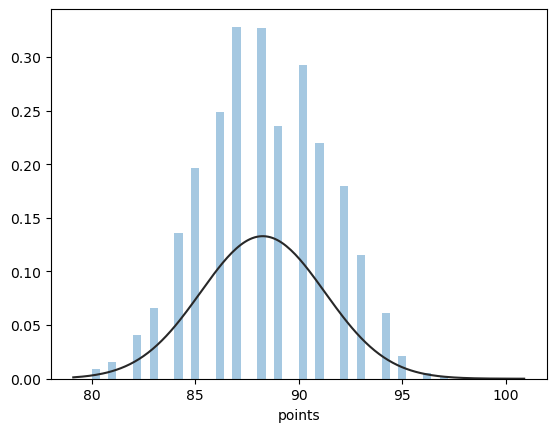

In [17]:
sns.distplot(df['points'], kde=False, fit=stats.norm)

<AxesSubplot:ylabel='Frequency'>

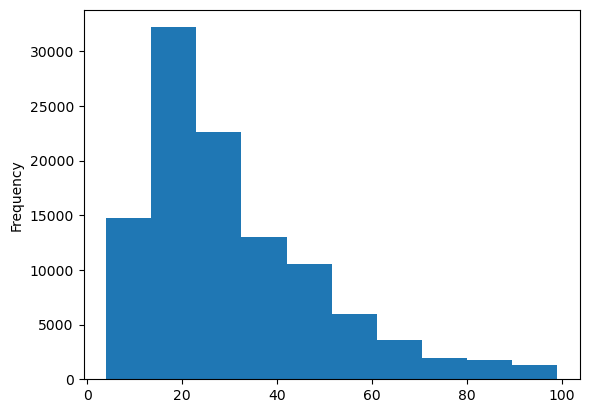

In [18]:
df[df['price'] < 100]['price'].plot.hist()

<AxesSubplot:xlabel='price', ylabel='points'>

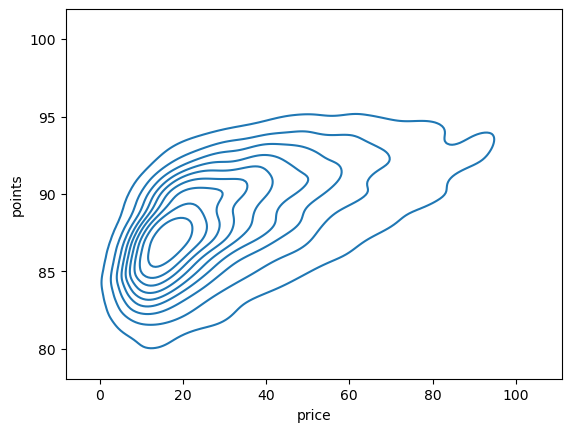

In [19]:
sns.kdeplot(data=df[df['price'] < 100].loc[:, ['price', 'points']].sample(10000), x='price', y='points')

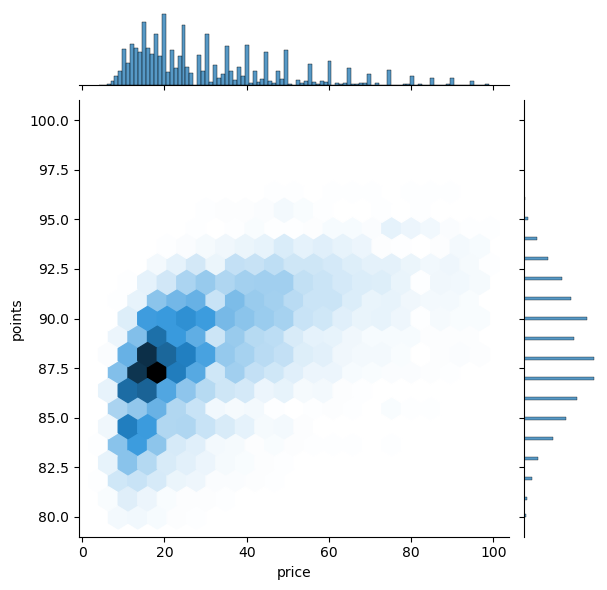

In [20]:
sns.jointplot(x='price', y='points', data=df[df['price'] < 100], kind='hex', gridsize=20)

<AxesSubplot:xlabel='variety', ylabel='points'>

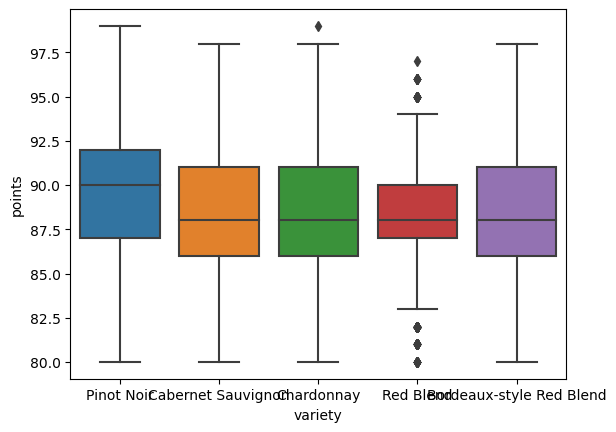

In [21]:
df_top_5 = df[df["variety"].isin(df["variety"].value_counts().head(5).index)]
sns.boxplot(data=df_top_5, x="variety", y="points")

<AxesSubplot:xlabel='points'>

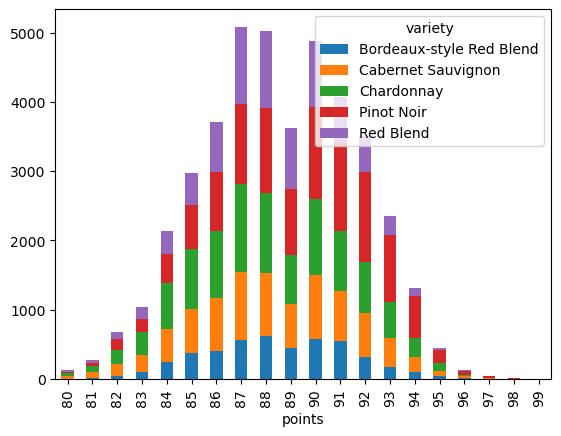

In [22]:
df_top_5[["points", "variety"]].value_counts().unstack().plot.bar(stacked=True)

<AxesSubplot:xlabel='points', ylabel='description_length'>

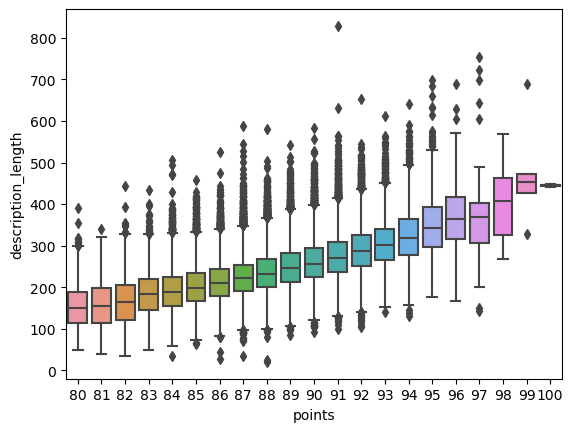

In [23]:
df["description_length"] = df["description"].apply(len)
sns.boxplot(data=df, x="points", y="description_length")


In [24]:

# JSON cleaning
with open("countries.json") as f:
    raw_countries_json = json.load(f)
countries_json = {"type": "FeatureCollection", "features" : []}
for feature in raw_countries_json["features"]:
    if feature["properties"]["name"] in df["country"].unique():
        countries_json["features"].append(feature)


In [25]:
m = folium.Map(location=[0, 0], zoom_start=2)

folium.Choropleth(
    geo_data=countries_json,
    data=df,
    columns=["country", "price"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    name="Price",
).add_to(m)

folium.LayerControl().add_to(m)

m

# Sentimental Analysis 

In [26]:
headers = ['pos','neg','neu','compound']
texts = df["description"]
analyzer = SentimentIntensityAnalyzer()
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df['description']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df['description']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df['description']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df['description']]

In [27]:
df

,country,description,points,price,province,variety,description_length,compound,neg,neu,pos
0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red,227,0.6486,0.000,0.872,0.128
1,United States of America,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,186,-0.1280,0.053,0.947,0.000
2,United States of America,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling,199,0.3400,0.000,0.930,0.070
3,United States of America,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir,249,0.8176,0.000,0.817,0.183
4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tempranillo-Merlot,261,0.1655,0.000,0.961,0.039
...,...,...,...,...,...,...,...,...,...,...,...
120910,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,Riesling,227,0.7331,0.000,0.838,0.162
120911,United States of America,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Pinot Noir,233,0.5267,0.000,0.916,0.084
120912,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Gewürztraminer,225,0.1548,0.068,0.873,0.059
120913,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Pinot Gris,216,0.5267,0.000,0.896,0.104


## WordClouds

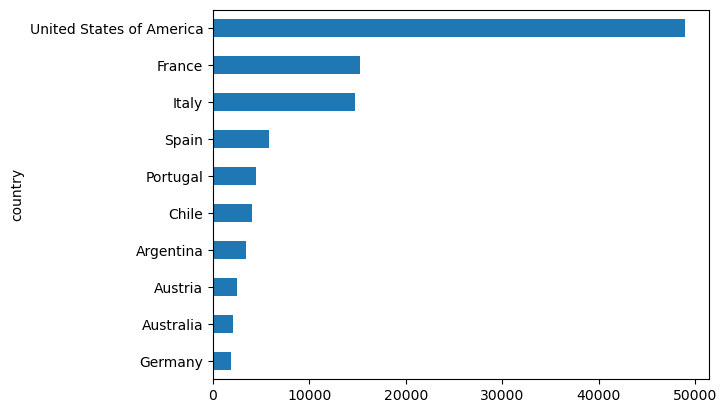

In [28]:
#Looking at number of reviews by each country to select country with most reviews for word cloud generation 
df1 = df["country"]
num_of_reviews = df1.groupby(df["country"]).count()
num = num_of_reviews.sort_values(ascending=True)

#Looking at reviews of top 10 countries 
reviews = num.tail(10)

bargraph = reviews.plot.barh(x='country', y='reviews[1]')

In [29]:
#Specifiying stopwords for the reviews

stopwords_reviews = ["wine", "review", "drink", "bottle", "flavor", "hint", "finish", "palate", "show", "now", "flavors", "shows", "fruit", "will", "give", "made"]
stopwords_updated = set(STOPWORDS)
stopwords_updated.update(stopwords_reviews)

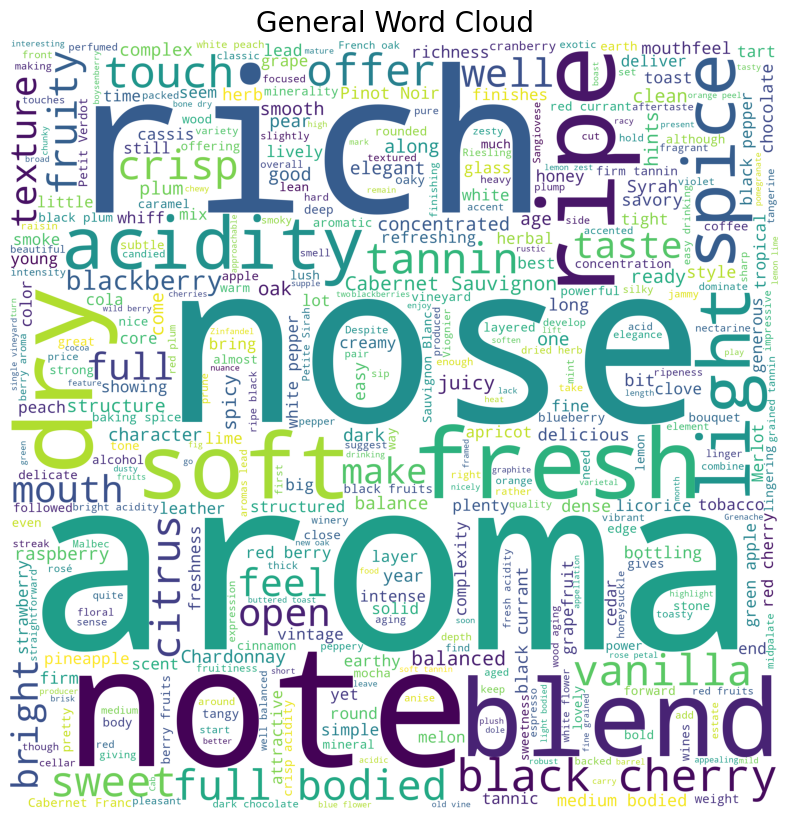

In [30]:
##Our code 

%matplotlib inline

text = df['description'].astype(str)
wordcloud = WordCloud(stopwords=stopwords_updated,
                      background_color='white',width=3000,height=3000, max_words=400).generate(" ".join(text)) 

print(wordcloud)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.title("General Word Cloud",fontsize=20)
plt.axis('off')
plt.show()

In [31]:
from collections import defaultdict
descriptions = defaultdict(list)
df.apply(lambda x: descriptions[x.country].append(x.description), axis=1)
#descriptions['US']#[0:5]

0         None
1         None
2         None
3         None
4         None
          ... 
120910    None
120911    None
120912    None
120913    None
120914    None
Length: 107726, dtype: object

In [32]:
import re
from PIL import Image
from IPython.display import Image as im
unwanted_characters = re.compile('[^A-Za-z ]+')
for country in list(df.country.unique()):
    desc_string = ' '.join(descriptions[country])
    descriptions[country] = ' '.join([w.lower() for w in re.sub(unwanted_characters, ' ', desc_string).split() if len(w) > 3])



In [33]:
def generate_country_wordcloud(words, mask_image, filename=None, colormap='jet'):
    mask = np.array(Image.open(mask_image))
    wc = WordCloud(background_color="white", max_words=3000, mask=mask, stopwords=stopwords_updated, colormap=colormap)
    wc.generate(words)
    if filename:
        wc.to_file(filename)
    return wc
    plt.figure(figsize = (12,16))

In [43]:
base = dict()
base['Argentina'] = r"argentina_bw_map.jpg"
base['Australia'] = r"australia_bw_map.jpg"
base['Austria'] = r"austria_bw_map.jpg"
base['Chile'] = r"chile_bw_map.jpg"
base['France'] = r"france_bw_map.jpg"
base['Italy'] = r"italy_bw_map.jpg"
base['Portugal'] = r"portugal_bw_map.jpg"
base['Spain'] = r"spain_bw_map.jpg"
base['US'] = r"usa_bw_map.jpg"
base['Germany'] = r"germany_bw_map.jpg"

In [44]:
words = descriptions['US']
us_wc = generate_country_wordcloud(words, base['US'], 'US.jpg')
us_wc.to_image()

TypeError: expected string or bytes-like object

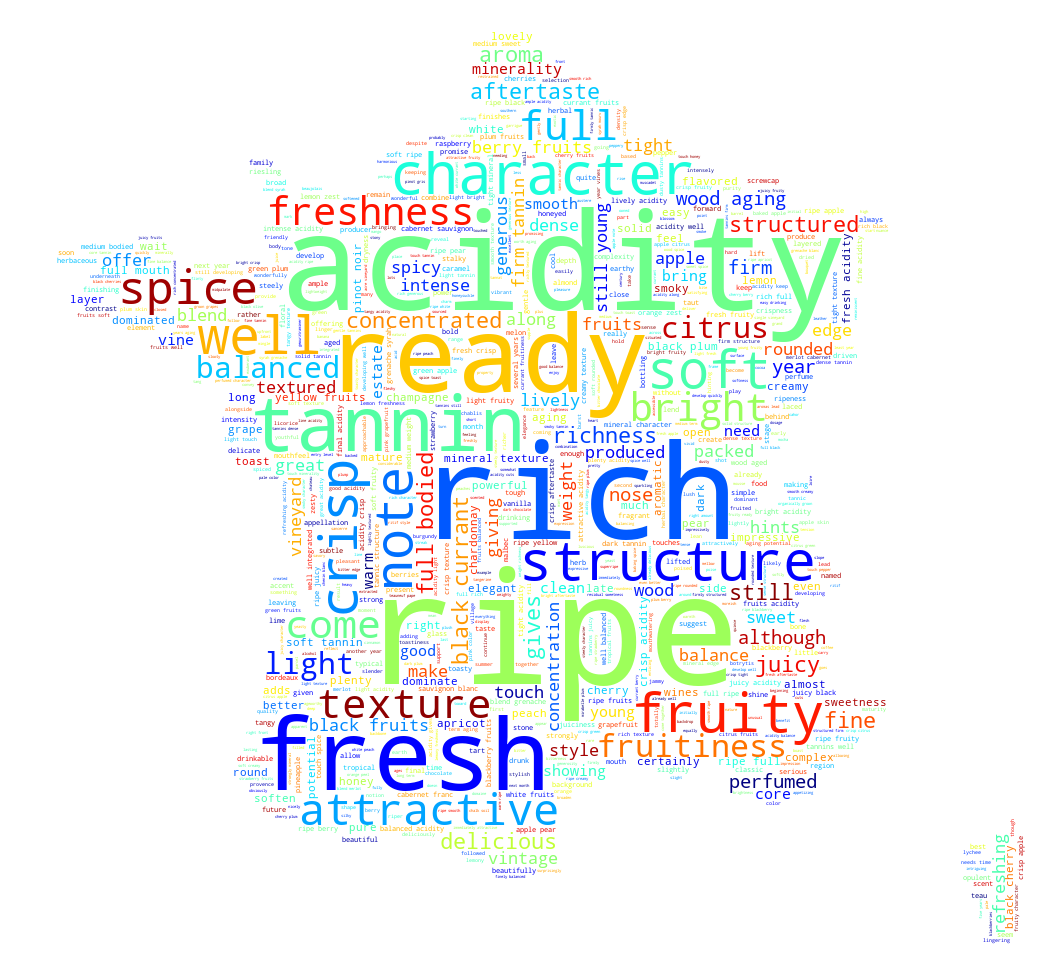

In [40]:
words = descriptions['France']
france_wc = generate_country_wordcloud(words, base['France'], 'France.jpg')
france_wc.to_image()

In [ ]:
words = descriptions['Italy']
italy_wc = generate_country_wordcloud(words, base['Italy'], 'Italy.jpg')
italy_wc.to_image()

In [ ]:
words = descriptions['Spain']
spain_wc = generate_country_wordcloud(words, base['Spain'], 'Spain.jpg')
spain_wc.to_image()

In [ ]:
words = descriptions['Portugal']
portugal_wc = generate_country_wordcloud(words,base ['Portugal'], 'Portugal.jpg')
portugal_wc.to_image()

In [ ]:
words = descriptions['Chile']
chile_wc = generate_country_wordcloud(words, base['Chile'], 'chile.jpg')
chile_wc.to_image()

In [ ]:
words = descriptions['Argentina']
argentina_wc = generate_country_wordcloud(words, base['Argentina'], 'argentina.jpg')
argentina_wc.to_image()

In [ ]:
words = descriptions['Austria']
austria_wc = generate_country_wordcloud(words, base['Austria'], 'austria.jpg')
austria_wc.to_image()

In [ ]:
words = descriptions['Australia']
australia_wc = generate_country_wordcloud(words, base['Australia'], 'australia.jpg')
australia_wc.to_image()

In [ ]:
words = descriptions['Germany']
germany_wc = generate_country_wordcloud(words, base['Germany'], 'germany.jpg')
germany_wc.to_image()

# Topic modelling

In [ ]:

texts = [[word for word in desc.lower().split() if word not in STOPWORDS and word.isalnum() and not word.lower() in ['wine', 'drink']] for desc in list(df["description"].values)]
dictionary = corpora.Dictionary(texts) #(word_id,word) pairs not word.lower() == 'slate'
corpus = [dictionary.doc2bow(text) for text in texts] #(word_id,freq) pairs by sentence


In [ ]:

num_topics = 10 #The number of topics that should be generated
passes = 10
lda = LdaModel(corpus, id2word=dictionary, num_topics=num_topics, passes=passes)


In [ ]:

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=10))

# Clustering with NLP and kMeans

In [ ]:
variety_df = df.groupby('variety').filter(lambda x: len(x) > 1500)
print(variety_df['variety'].unique())
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()



In [ ]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = variety_df['description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X = vectorizer.fit_transform(desc)
words = vectorizer.get_feature_names_out()

In [ ]:

kmeans = KMeans(n_clusters = len(variety_df['variety'].unique()))
kmeans.fit(X)



In [ ]:

common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))


In [ ]:

variety_df['cluster'] = kmeans.labels_
clusters = variety_df.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")


# One-hot coding

In [89]:
country_array = pd.get_dummies(df[df.columns[0]].values)
province_array =pd.get_dummies(df[df.columns[4]].values)
vareity_array = pd.get_dummies(df[df.columns[5]].values)

In [90]:
train_df = [df['price'],df['compound'],df['neg'],df['neu'],df['pos'],country_array,province_array,vareity_array,df['points']]
df_model = pd.concat(train_df, axis=1)

In [91]:
df_model.dropna(inplace = True)

In [92]:
df_model

,price,compound,neg,neu,pos,Argentina,Armenia,Australia,Austria,Bosnia and Herzegovina,...,Yapincak,Zibibbo,Zierfandler,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Çalkarası,Žilavka,points
1,15.0,0.6486,0.000,0.872,0.128,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
2,14.0,-0.1280,0.053,0.947,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
3,13.0,0.3400,0.000,0.930,0.070,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
4,65.0,0.8176,0.000,0.817,0.183,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
5,15.0,0.1655,0.000,0.961,0.039,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117019,14.0,0.3400,0.000,0.921,0.079,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0
117020,21.0,-0.2263,0.064,0.936,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0
117021,10.0,0.0000,0.000,1.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0
117022,19.0,0.1513,0.138,0.689,0.172,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0


# Correlation


In [ ]:
from scipy.stats import pearsonr
print("Pearson Correlation:", pearsonr(df.price, df.points))

In [28]:
import statsmodels.api as sm
print(sm.OLS(df.points, df.price).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                 points   R-squared (uncentered):                   0.440
Model:                            OLS   Adj. R-squared (uncentered):              0.440
Method:                 Least Squares   F-statistic:                          9.503e+04
Date:                Mon, 05 Dec 2022   Prob (F-statistic):                        0.00
Time:                        15:06:41   Log-Likelihood:                     -6.7854e+05
No. Observations:              120915   AIC:                                  1.357e+06
Df Residuals:                  120914   BIC:                                  1.357e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

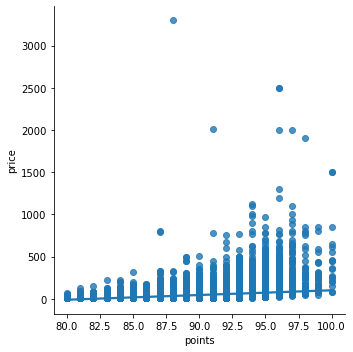

In [29]:
import seaborn as sns
sns.lmplot(y = 'price', x='points', data=df)

# Split 

In [50]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_model, test_size = 0.3)
x_train = train.iloc[0:,0:-1]#independent variables 
y_train = train['points']# last column 
x_test = test.iloc[0:,0:-1]
y_test = test['points']
x_train

,price,compound,neg,neu,pos,Argentina,Armenia,Australia,Austria,Bosnia and Herzegovina,...,Xynisteri,Yapincak,Zibibbo,Zierfandler,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Çalkarası,Žilavka
107716,16.0,0.8847,0.000,0.704,0.296,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80878,20.0,0.3182,0.000,0.938,0.062,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38056,15.0,0.6705,0.000,0.893,0.107,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
66212,14.0,0.0000,0.000,1.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98659,10.0,0.8553,0.000,0.749,0.251,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6306,14.0,-0.0735,0.090,0.829,0.080,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64671,16.0,-0.0516,0.125,0.758,0.117,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64390,62.0,0.7430,0.000,0.826,0.174,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28398,30.0,0.0000,0.000,1.000,0.000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Linear Regression

In [60]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

model = linear_model.LinearRegression()
model.fit(x_train,y_train)
model.coef_

array([ 8.01595950e-02,  3.97065849e+00,  5.72292714e+01, ...,
       -3.26016718e+06, -3.26017053e+06, -3.26017092e+06])

In [61]:
from sklearn.metrics import r2_score
import math
training_predictions = model.predict(x_train)
testing_predictions  = model.predict(x_test)
#r2_score(y_test, testing_predictions)
mse = mean_squared_error(y_test, testing_predictions)
rmse = math.sqrt(mse)
mse
#metrics.accuracy_score(y_test, y_pred)

25097462584423.22

In [62]:
print("Training R-Square",model.score(x_train,y_train))
print("Testing R-Square",model.score(x_test,y_test))

Training R-Square 0.3983929879986058
Testing R-Square -2911051368674.513


In [63]:

r2_score(y_test, testing_predictions)


-2911051368674.513

# Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logit = LogisticRegression()
logit.fit(x_train,y_train)
y_pred = logit.predict(x_test)


In [65]:
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
rmse

2.4740845264762625

In [66]:
r2_score(y_test, y_pred)

0.29001508749008653

In [68]:
#from sklearn import metrics
#metrics.accuracy_score(y_test, y_pred)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree


for i in range(10,30):
    dt_model = tree.DecisionTreeRegressor(max_depth=i)
#model = DecisionTreeRegressor(max_depth = 3)
    print(i,dt_model.fit(x_train,np.ravel(y_train)),dt_model.score(X=x_test, y=y_test))
y_pred =dt_model.predict(x_test)

In [69]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
dt_model = tree.DecisionTreeRegressor(max_depth=17)
dt_model.fit(x_train,np.ravel(y_train))
dt_model.score(X=x_test, y=y_test)
y_pred =dt_model.predict(x_test)
#metrics.accuracy_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))

2.4133633467873823
0.3244375862191127


In [ ]:
accuracy_score(y_test, y_pred)

# RandomForestClassifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=20,min_samples_leaf=10,min_samples_split=10,n_estimators=100)
#np.ravel flattens the pandas Series into an np array. That's what the classifier needs
rf_model.fit(x_train,np.ravel(y_train))
y_pred =rf_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))

2.522391814936409
0.2639876218417384


In [77]:
y_pred =rf_model.predict(x_test).round()
accuracy_score(y_test, y_pred)

0.16192970365265336

# BaggingClassifier

In [72]:
from sklearn.ensemble import BaggingClassifier
b_model=BaggingClassifier()
b_model.fit(x_train,np.ravel(y_train))
y_pred =b_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))

2.629450535792051
0.19804487980909335


In [79]:
accuracy_score(y_test, y_pred)

0.19354927636113026

# KNN

In [73]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train,y_train)
knn.score(x_test, y_test)

y_pred =knn.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))

2.4691413642264064
0.29284931935282754


In [38]:
mse = mean_squared_error(y_test, knn.predict(x_test))
rmse = math.sqrt(mse)
rmse

2.4199868428938744

In [103]:
accuracy_score(y_test, knn.predict(x_test).round())

0.17739490006891798

# Making Points Categorical

In [54]:
# Assign levels base on points of the wine to make points categorical data
for i in df_model['points']:
    if i > 95:
        df_model['level'] = 'A'
    elif i < 95 and i>= 90:
        df_model['level'] = 'B'
    elif i < 90 and i >= 85:
        df_model['level'] = 'C'
    elif i < 85 and i>= 80:
        df_model['level'] = 'D'


In [57]:
df_classif = df_model

# Split data

In [68]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_classif, test_size = 0.3)
x_train = train.iloc[0:,0:-1]#independent variables 
y_train = train['points']# last column 
x_test = test.iloc[0:,0:-1]
y_test = test['points']
y_train

69292     85.0
81157     84.0
53668     88.0
89058     92.0
100898    87.0
          ... 
101437    83.0
102959    91.0
63579     93.0
79202     90.0
17289     94.0
Name: points, Length: 73778, dtype: float64

# RandomForestClassifier

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=100)
#np.ravel flattens the pandas Series into an np array. That's what the classifier needs
rf_model.fit(x_train,np.ravel(y_train))
y_pred =rf_model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)
print(r2_score(y_test, y_pred))
accuracy_score(y_test, y_pred)

0.6080318411050497
0.9573852134621372


0.9022770398481973

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model2 = SVC(kernel='linear', C=10) # kernel and C are the main args to adjust for linear SVC
model2.fit(x_train, y_train)
model2.score(x_train, y_train)

# Recommendation system

In [ ]:
from sklearn.neighbors import NearestNeighbors # KNN Clustering 
from scipy.sparse import csr_matrix # Compressed Sparse Row matrix
from sklearn.decomposition import TruncatedSVD # Dimensional Reduction

In [ ]:
col = ['province','variety','points']

wine1 = df[col]
wine1 = wine1.dropna(axis=0)
wine1 = wine1.drop_duplicates(['province','variety'])
wine1 = wine1[wine1['points'] > 85]

wine_pivot = wine1.pivot(index= 'variety',columns='province',values='points').fillna(0)
wine_pivot_matrix = csr_matrix(wine_pivot)


In [ ]:

knn = NearestNeighbors(n_neighbors=10, algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(wine_pivot_matrix)



In [ ]:

for n in range(3):
    query_index = np.random.choice(wine_pivot.shape[0])
    #print(n, query_index)
    distance, indice = model_knn.kneighbors(wine_pivot.iloc[query_index,:].values.reshape(1,-1), n_neighbors=6)
    for i in range(0, len(distance.flatten())):
        if  i == 0:
            print('Recommendation for ## {0} ##:'.format(wine_pivot.index[query_index]))
        else:
            print('{0}: {1} with distance: {2}'.format(i,wine_pivot.index[indice.flatten()[i]],distance.flatten()[i]))
    print('\n')